In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns
from joblib import Parallel, delayed
import os

sns.set_palette('Set2')
cmap = sns.color_palette('Set2')

In [25]:
Tmax = 200
time_step = 0.5
nsteps = int(Tmax / time_step) +1
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]

R_eff = 3
t_lockdown = 30


eta = 0.2

gmean = 4.87
gsd = 1.98
a = gmean**2 / gsd**2
b = gsd**2 / gmean



# Define distributions for the lifetime, infectivity profile and population-level transmission rate
# For Crump-Mode-Jagers Process

def lifetime(t):
    return sp.stats.gamma.cdf(t, a = a, scale = b) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t):
    return sp.stats.gamma.pdf(t, a = a, scale = b) # sp.stats.expon.pdf(t, scale = 1/gamma_test)

def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = a, scale = b)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = a, scale = b)

#def Rt(t, R=R_eff):
#    return R
Rt = 3 * np.ones_like(time)

def intensity_measure(t):
    return R_eff * infectiousness_pdf(t) * (1-lifetime(t)) #* (1-lifetime(t, 0))


R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

R0 is: 1.5000000000000147


In [572]:
#Poisson_generator(R_eff, infectiousness_pdf(time)[:100], 0.5)
def foi_t(t, time_step = time_step):
    return R_eff * (infectiousness(t) - infectiousness(t-time_step)) 

lambdaMax = np.max(foi_t(time))
print(lambdaMax)


# Arrival times in poisson process - snap to grid of points
def inhomogeneous_poisson(rate, bin_size, lamMax):
    arrival_times = []
    t = 0
    while t <= 20:
        u1 = np.random.rand()
        t = t - (1/lamMax)*np.log(u1)
        u2 = np.random.rand()
        if u2 < (rate(t)/lamMax):
            arrival_times += [int((t - t%bin_size)/bin_size) + 1]
    return arrival_times


inhomogeneous_poisson(foi_t, 0.5, lambdaMax)


0.32281712651393313


[]

In [584]:
nsims = 30000

def CMJsimulate(nsims, time, infectiousness, Z0, Zstar = 1000):
    nsteps = len(time)
    h = time[1]-time[0]
    Z=np.zeros((nsims, int(nsteps)))
    Z[:, 0] = Z0
    prev = np.zeros((nsims, int(nsteps)))

    tstops = np.zeros(nsims)
    #nintervals = int(T/h)
    for i in tqdm(range(nsims)):
    
        for t in range(len(time)):
            
            nlifetimes = int(Z[i, t])

            # Generate all lifetimes at once
            lifetimes = (np.random.gamma(a, b, size = nlifetimes))
            intervals = t + lifetimes 
            diff = (intervals + 1) % h 
            recoveries = ((intervals - diff)/h).astype(int)
            
            if len(recoveries) == 0:
                continue
                
            # Generate all of the infections that each individual will make via a Poisson process 
            for r in recoveries:
                if t + r <= len(time - 1):
                    prev[i, t:(t+r)] += 1
                else:
                    prev[i, t:] += 1
                if r == 0: # Avoid case where r-1 = -1
                    continue
                arrivals = inhomogeneous_poisson(foi_t, h, lambdaMax)
                for ar in arrivals:
                    arrival_idx = t + ar
                    if arrival_idx <= (len(time)-1):
                        Z[i, arrival_idx] += 1
            if prev[i, t] >= Zstar:
                tstops[i] = time[t]
                break
            
    return tstops

fptsims = CMJsimulate(nsims, time, infectiousness, 1)

100%|██████████| 30000/30000 [2:25:51<00:00,  3.43it/s]  


In [585]:
np.savetxt('FPT_sim_R=' + str(np.round(R_eff/2, 1)) + '.csv', fptsims[fptsims!=0])

In [586]:
np.savetxt('FPT_sim_R=' + str(np.round(R_eff/2, 1)) + '_large.csv', fptsims[fptsims!=0])

In [511]:
fptsims = np.genfromtxt('FPT_sim_R=' + str(np.round(R_eff/2, 1)) + '.csv')

In [471]:

pmf = np.genfromtxt('pmf_test_large.csv')


In [580]:

mean = bp.mean_pmf(pmf)
extinction = pmf[0, :]
Zstar = 175
try:
    tstar_idx = np.argwhere(mean >= Zstar)[1][0]#np.argwhere(np.gradient(extinction, time_step)<= 0.0001)[1][0]
except:
    tstar_idx = -1
tstar = time[tstar_idx]
#int(mean[tstar_idx]) + 1
FPT_cdf = bp.FirstPassageTime(pmf, Zstar, time, False)
fpt_pdf = np.gradient(FPT_cdf, time_step)


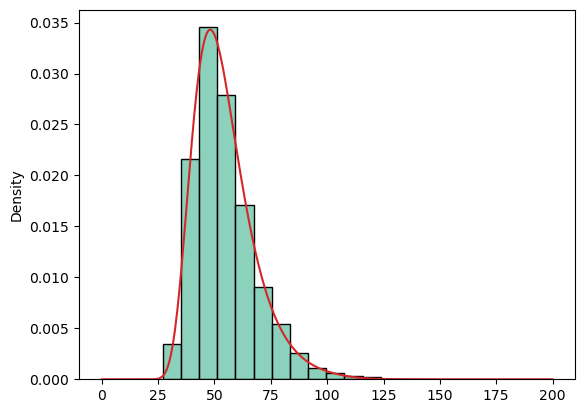

In [581]:
sns.histplot(fptsims[fptsims!=0] , stat = 'density', bins = 15)
plt.plot(time, fpt_pdf, color = 'tab:red')